In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/first/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/test/"

In [16]:
batch_size = 32
torch.manual_seed(0) # random seed
# E type :250
# I type :196
# Sc type :569
train_trans = transforms.Compose([transforms.RandomHorizontalFlip(),
                                  transforms.Resize((255, 255)), 
                                  transforms.ToTensor()
                                 ])
# class_weights = [250/1015, 196/1015, 569/1015]
# weights = 1. / torch.tensor(class_weights, dtype=torch.float)
# print(weights)
# # samples_weights = weights[train_targets]

# sampler = WeightedRandomSampler(
#     weights=weights,
#     num_samples=len(weights),
#     replacement=True)

train_data = ImageFolder(train_image_path, transform = train_trans)
train_set_size = int(len(train_data) * 0.85)
valid_set_size = len(train_data) - train_set_size

train_set, valid_set = torch.utils.data.random_split(train_data, [train_set_size, valid_set_size])
train_loader = DataLoader(train_set, batch_size = batch_size, pin_memory = True)

print(len(train_set))
val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
# val_data = ImageFolder(test_image_path, transform = val_trans)
val_loader = DataLoader(valid_set)
print(len(valid_set))
test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data)

862
153


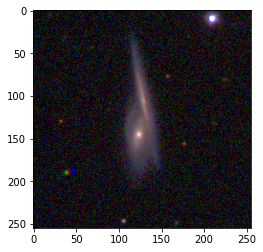

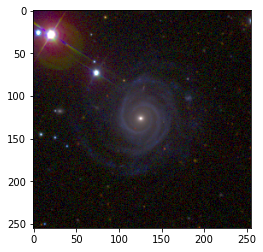

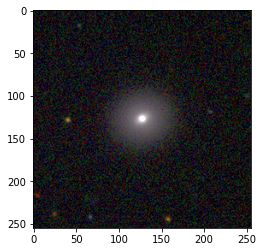

In [17]:
images, labels = next(iter(train_loader))

# for i in np.arange(3):
#   plt.figure(i)
#   plt.imshow(images[i].permute(1, 2, 0))
#   plt.show()


# After Normalize
for i in np.arange(3):
  plt.figure(i)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.show()
# Before Normalize
# for i in np.arange(3):
#   plt.figure(i)
#   # Our data are normalized, in order to watch our origin image, so we need to denormalize our data
#   mean = torch.tensor([0.485, 0.456, 0.406])
#   std = torch.tensor([0.229, 0.224, 0.225])
#   tmp = transforms.Normalize(-mean/std, 1/std)(images[i]) # denormalize
#   plt.imshow(tmp.permute(1, 2, 0)) # The data in pytorch is (channel, size, size), and we need to change it to (size, size, channel)
#   plt.show()

In [18]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 512), # Fully-connected layer
        nn.Dropout(0.25), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [19]:
model = Galaxy()
# model = torchvision.models.vgg16()
model = model.to(device)
print(model)

Galaxy(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=512, bias=Tru

In [20]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

n_epochs = 30
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
for epoch in range(n_epochs):
  train_loss = 0.0
  val_loss = 0.0
  train_acc = 0.0
  val_acc = 0.0
  model.train()

  for x, y in tqdm(train_loader):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    prediction = model(x)
    loss = loss_func(prediction, y)
    loss.backward()
    optimizer.step()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    train_acc += acc/len(train_loader)
    train_loss += loss/len(train_loader)

  print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
  train_loss_record.append(train_loss)
  train_acc_record.append(train_acc)

  model.eval()
  for x, y in tqdm(val_loader):
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    val_acc += acc/len(val_loader)
    val_loss += loss/len(val_loader)
  print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
  val_loss_record.append(val_loss)
  val_acc_record.append(val_acc)
torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 1/30 ] loss = 1.03561, acc = 0.51373


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 1/30 ] loss = 0.93955, acc = 0.63399


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 2/30 ] loss = 0.98128, acc = 0.54730


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 2/30 ] loss = 0.85734, acc = 0.63399


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 3/30 ] loss = 0.87469, acc = 0.60664


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 3/30 ] loss = 0.78941, acc = 0.67320


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 4/30 ] loss = 0.75995, acc = 0.68665


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 4/30 ] loss = 0.59937, acc = 0.76471


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 5/30 ] loss = 0.70490, acc = 0.68318


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 5/30 ] loss = 0.55718, acc = 0.79085


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 6/30 ] loss = 0.61140, acc = 0.74012


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 6/30 ] loss = 0.56813, acc = 0.81699


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 7/30 ] loss = 0.55484, acc = 0.78889


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 7/30 ] loss = 0.45668, acc = 0.84314


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 8/30 ] loss = 0.51262, acc = 0.80733


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 8/30 ] loss = 0.41657, acc = 0.85621


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 9/30 ] loss = 0.44951, acc = 0.82924


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 9/30 ] loss = 0.39273, acc = 0.87582


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 10/30 ] loss = 0.40012, acc = 0.85494


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 10/30 ] loss = 0.33741, acc = 0.86275


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 11/30 ] loss = 0.37700, acc = 0.86427


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 11/30 ] loss = 0.26627, acc = 0.88889


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 12/30 ] loss = 0.31901, acc = 0.88858


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 12/30 ] loss = 0.26989, acc = 0.90196


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 13/30 ] loss = 0.28693, acc = 0.90718


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 13/30 ] loss = 0.29000, acc = 0.89542


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 14/30 ] loss = 0.28504, acc = 0.90710


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 14/30 ] loss = 0.28105, acc = 0.90850


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 15/30 ] loss = 0.27237, acc = 0.91165


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 15/30 ] loss = 0.27329, acc = 0.90850


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 16/30 ] loss = 0.25717, acc = 0.92099


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 16/30 ] loss = 0.27893, acc = 0.91503


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 17/30 ] loss = 0.24871, acc = 0.91744


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 17/30 ] loss = 0.31150, acc = 0.91503


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 18/30 ] loss = 0.25362, acc = 0.91397


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 18/30 ] loss = 0.26482, acc = 0.91503


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 19/30 ] loss = 0.22105, acc = 0.92446


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 19/30 ] loss = 0.26152, acc = 0.92810


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 20/30 ] loss = 0.23119, acc = 0.91860


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 20/30 ] loss = 0.27055, acc = 0.92157


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 21/30 ] loss = 0.21937, acc = 0.93140


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 21/30 ] loss = 0.24683, acc = 0.92810


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 22/30 ] loss = 0.20825, acc = 0.93495


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 22/30 ] loss = 0.21494, acc = 0.94771


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 23/30 ] loss = 0.23173, acc = 0.92778


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 23/30 ] loss = 0.24349, acc = 0.92157


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 24/30 ] loss = 0.21463, acc = 0.93140


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 24/30 ] loss = 0.23474, acc = 0.95425


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 25/30 ] loss = 0.21986, acc = 0.91983


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 25/30 ] loss = 0.21458, acc = 0.95425


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 26/30 ] loss = 0.19179, acc = 0.93850


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 26/30 ] loss = 0.22883, acc = 0.93464


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 27/30 ] loss = 0.18075, acc = 0.93495


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 27/30 ] loss = 0.21758, acc = 0.93464


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 28/30 ] loss = 0.19152, acc = 0.93140


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 28/30 ] loss = 0.26355, acc = 0.89542


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 29/30 ] loss = 0.19062, acc = 0.93032


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 29/30 ] loss = 0.20967, acc = 0.95425


  0%|          | 0/27 [00:00<?, ?it/s]

[ Train | 30/30 ] loss = 0.17592, acc = 0.94421


  0%|          | 0/153 [00:00<?, ?it/s]

[ Validation | 30/30 ] loss = 0.19459, acc = 0.94118


In [22]:
model.eval()
# for x, y in test_loader:
#   x, y = x.to(device), y.to(device)
#   prediction = model(x)
#   loss = loss_func(prediction, y)
#   loss.backward()
#   acc = ((prediction.argmax(dim = 1) == y).float().mean())
# print(f"[ Test ] loss = {loss:.5f}, acc = {acc:.5f}")
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(val_loader)
    test_loss += loss/len(val_loader)
print(f"[ Test ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")

[ Test ] loss = 0.19459, acc = 0.94118


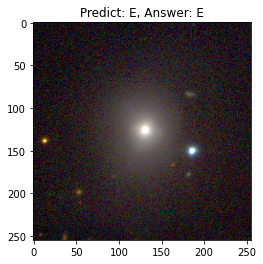

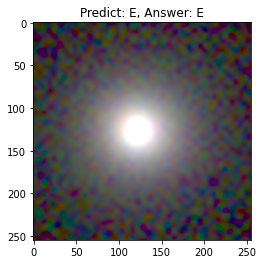

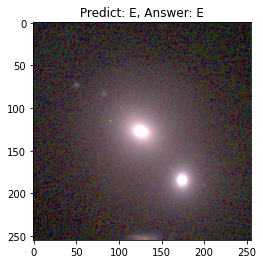

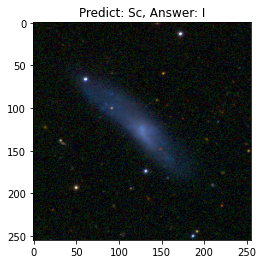

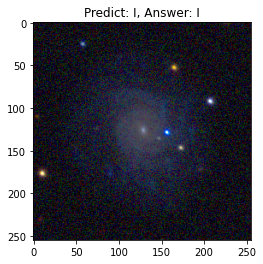

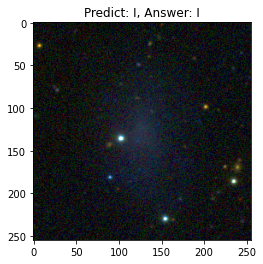

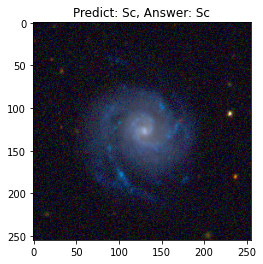

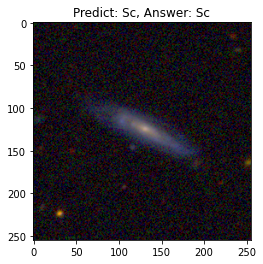

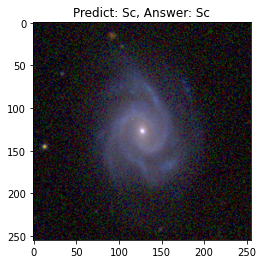

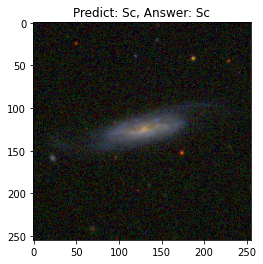

In [23]:
i = 0
for x, y in test_loader:
  i += 1
  if train_on_gpu:
    x, y = x.cuda(), y.cuda()
  output = model(x)
  out = output.argmax(dim = 1)
  out = out.to('cpu').numpy()
  # print(out)
  if y == 0:
    ans = 'E'
  elif y == 1:
    ans = 'I'
  else:
    ans = 'Sc'
  if i % 10 == 0:
    plt.figure(i)
    if out[0] == 0:
      plt.title(f'Predict: E, Answer: {ans}')
    elif out[0] == 1:
      plt.title(f'Predict: I, Answer: {ans}')
    else:
      plt.title(f'Predict: Sc, Answer: {ans}')
    x = x.squeeze()
    x = x.to('cpu')
#     mean = torch.tensor([0.485, 0.456, 0.406])
#     std = torch.tensor([0.229, 0.224, 0.225])
#     tmp = transforms.Normalize(-mean/std, 1/std)(images[i]) # denormalize
    plt.imshow(x.permute(1, 2, 0))
    plt.show()

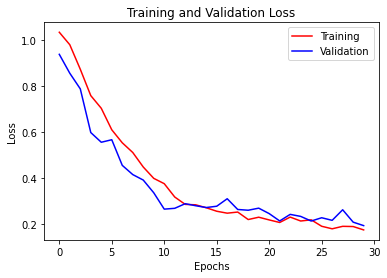

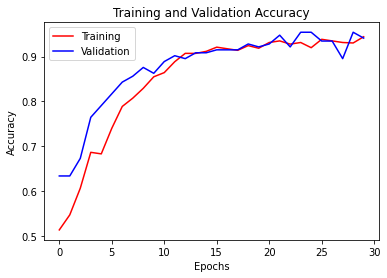

In [24]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()